# Lecture 9: Risk and Return

## MIT 15.401 — Finance Theory I (Prof. Andrew Lo)

---

**Video:** [MIT OCW — Risk and Return](https://ocw.mit.edu/courses/15-401-finance-theory-i-fall-2008/pages/video-lectures-and-slides/risk-and-return/) (2 parts)

**Readings:** Brealey, Myers, and Allen — Chapter 7

---

With Sessions 1–8, we've built a rich toolkit: present value, bond pricing, equity valuation, forwards and futures, and options. But one critical question has been lurking beneath the surface since Session 1: **where does the discount rate come from?**

Every NPV calculation requires a cost of capital. Every bond is priced relative to a risk-free rate plus a spread. The Gordon Growth Model uses a "required return" $r$. But how does the market determine $r$? The answer begins here.

This session introduces **risk** into the valuation framework. We develop the statistical tools to measure risk (mean, variance, standard deviation, correlation, skewness), examine the empirical properties of U.S. stock returns going back to 1926, and document the key **anomalies** that have fascinated (and troubled) financial economists for decades: the size effect, the value premium, momentum, and the January effect.

This is the gateway to **Part C** of the course: Portfolio Theory (Session 10), the CAPM and APT (Session 11), and Capital Budgeting (Session 12).

## Table of Contents

1. [Motivation: Why Risk Matters](#1-motivation)
2. [Statistical Background](#2-statistics)
3. [Empirical Properties of U.S. Stock Returns](#3-empirical)
4. [The Random Walk and Market Efficiency](#4-random-walk)
5. [Time-Varying Volatility](#5-volatility)
6. [Anomalies](#6-anomalies)
7. [Key Summary Statistics](#7-summary)
8. [Exercises](#8-exercises)

In [4]:
# ============================================================
# Setup
# ============================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from scipy.stats import norm, skew, kurtosis
from scipy import stats

plt.rcParams.update({
    'figure.figsize': (10, 5),
    'axes.spines.top': False,
    'axes.spines.right': False,
    'axes.grid': True,
    'grid.alpha': 0.3,
    'font.size': 12,
    'lines.linewidth': 2,
})

np.random.seed(42)
print("Libraries loaded successfully.")

Libraries loaded successfully.


---

<a id='1-motivation'></a>
## 1. Motivation: Why Risk Matters

### The Cost of Capital Problem (Lo's Slide 3)

NPV and all other valuation techniques require a **cost of capital**:
- **Opportunity cost:** what you could earn on an alternative investment of similar risk
- **Required rate of return:** the minimum return investors demand for bearing a given level of risk
- **Risk-adjusted discount rate:** the rate at which risky cash flows should be discounted

This rate is "determined by the market" — but **how**?

To answer this, we need to:
1. **Measure risk** — what is risk, mathematically?
2. **Estimate the required return** for a given level of risk
3. **Understand the empirical relationship** between risk and return

### Three Related Questions

Lo frames the practical importance through three questions:
- How risky are stocks, and what have their returns been historically?
- Is the stock market "efficient"?
- How can we gauge the performance of portfolio managers?

All three require the statistical machinery we develop in this session.

---

<a id='2-statistics'></a>
## 2. Statistical Background

### Asset Returns

The **simple return** on an asset over one period is:

$$R_t = \frac{P_t + D_t - P_{t-1}}{P_{t-1}} = \frac{P_t + D_t}{P_{t-1}} - 1$$

where $P_t$ is the price at the end of period $t$ and $D_t$ is the dividend (or coupon) paid during period $t$. The **total return** includes both price appreciation and income.

### Key Statistics (Lo's Slides 5–9)

| Statistic | Formula | Interpretation |
|-----------|---------|----------------|
| **Mean** (expected return) | $\mu = E[R] = \frac{1}{T}\sum_{t=1}^T R_t$ | Average return; central tendency |
| **Variance** | $\sigma^2 = E[(R - \mu)^2] = \frac{1}{T-1}\sum_{t=1}^T (R_t - \bar{R})^2$ | Dispersion around the mean |
| **Standard deviation** | $\sigma = \sqrt{\sigma^2}$ | Risk; same units as return |
| **Skewness** | $\text{Skew} = E\left[\left(\frac{R-\mu}{\sigma}\right)^3\right]$ | Asymmetry; negative = big losses more likely |
| **Kurtosis** | $\text{Kurt} = E\left[\left(\frac{R-\mu}{\sigma}\right)^4\right]$ | Fat tails; high kurtosis = extreme events |
| **Correlation** | $\rho_{12} = \frac{\text{Cov}(R_1, R_2)}{\sigma_1 \sigma_2}$ | Co-movement; $\rho \in [-1, 1]$ |

### Investor Preferences (Wang Lecture Notes)

The lecture notes formalize three assumptions that will carry through the rest of the course:

1. **Higher mean is preferred:** investors like higher expected returns.
2. **Higher standard deviation is disliked:** investors are risk-averse.
3. **Investors care only about mean and standard deviation** (or equivalently, variance).

Under these three assumptions, **standard deviation is the measure of risk**. This is the foundation for mean-variance analysis (Session 10).

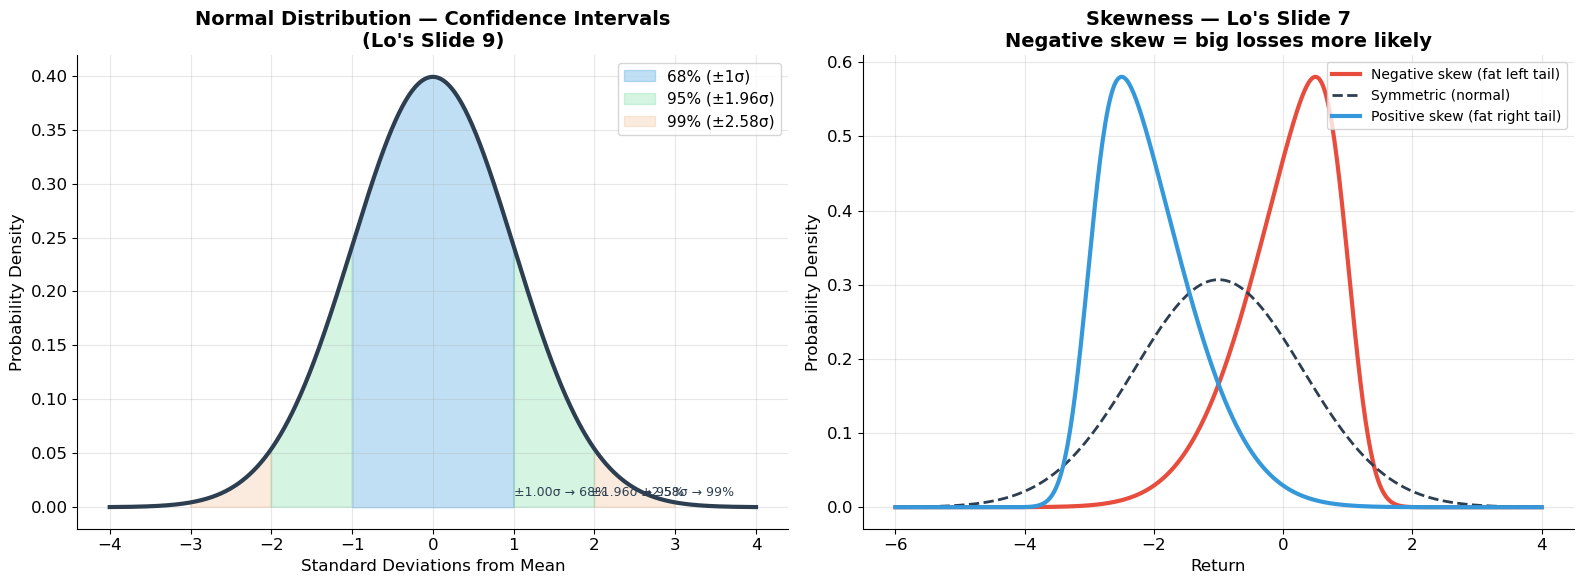

Normal distribution confidence intervals:
  68% of observations within ±1.00 standard deviations
  90% of observations within ±1.65 standard deviations
  95% of observations within ±1.96 standard deviations
  99% of observations within ±2.58 standard deviations


In [7]:
# ============================================================
# The Normal Distribution and Confidence Intervals (Lo's Slide 9)
# ============================================================
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Left: Normal distribution with confidence intervals
x = np.linspace(-4, 4, 1000)
y = norm.pdf(x)

axes[0].plot(x, y, color='#2c3e50', linewidth=3)
axes[0].fill_between(x, y, where=(x >= -1) & (x <= 1), alpha=0.3, color='#3498db', label='68% (±1σ)')
axes[0].fill_between(x, y, where=((x >= -2) & (x < -1)) | ((x > 1) & (x <= 2)), 
                     alpha=0.2, color='#2ecc71', label='95% (±1.96σ)')
axes[0].fill_between(x, y, where=((x >= -3) & (x < -2)) | ((x > 2) & (x <= 3)), 
                     alpha=0.15, color='#e67e22', label='99% (±2.58σ)')
axes[0].set_xlabel('Standard Deviations from Mean', fontsize=12)
axes[0].set_ylabel('Probability Density', fontsize=12)
axes[0].set_title('Normal Distribution — Confidence Intervals\n(Lo\'s Slide 9)', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=11)

# Annotations
for z, pct in [(1.0, '68%'), (1.96, '95%'), (2.58, '99%')]:
    axes[0].annotate(f'±{z:.2f}σ → {pct}', xy=(z, 0.01), fontsize=9, color='#2c3e50')

# Right: Skewness illustration
ax = axes[1]
# Negative skew (Lo's slide 7)
from scipy.stats import skewnorm
x_sk = np.linspace(-6, 4, 500)
y_neg = skewnorm.pdf(x_sk, a=-4, loc=1, scale=1.2)
y_pos = skewnorm.pdf(x_sk + 2, a=4, loc=-1, scale=1.2)
y_sym = norm.pdf(x_sk + 1, loc=0, scale=1.3)

ax.plot(x_sk, y_neg, color='#e74c3c', linewidth=3, label='Negative skew (fat left tail)')
ax.plot(x_sk, y_sym, color='#2c3e50', linewidth=2, linestyle='--', label='Symmetric (normal)')
ax.plot(x_sk, y_pos, color='#3498db', linewidth=3, label='Positive skew (fat right tail)')
ax.set_xlabel('Return', fontsize=12)
ax.set_ylabel('Probability Density', fontsize=12)
ax.set_title('Skewness — Lo\'s Slide 7\nNegative skew = big losses more likely', fontsize=14, fontweight='bold')
ax.legend(fontsize=10)

plt.tight_layout()
plt.show()

print("Normal distribution confidence intervals:")
print("  68% of observations within ±1.00 standard deviations")
print("  90% of observations within ±1.65 standard deviations")
print("  95% of observations within ±1.96 standard deviations")
print("  99% of observations within ±2.58 standard deviations")

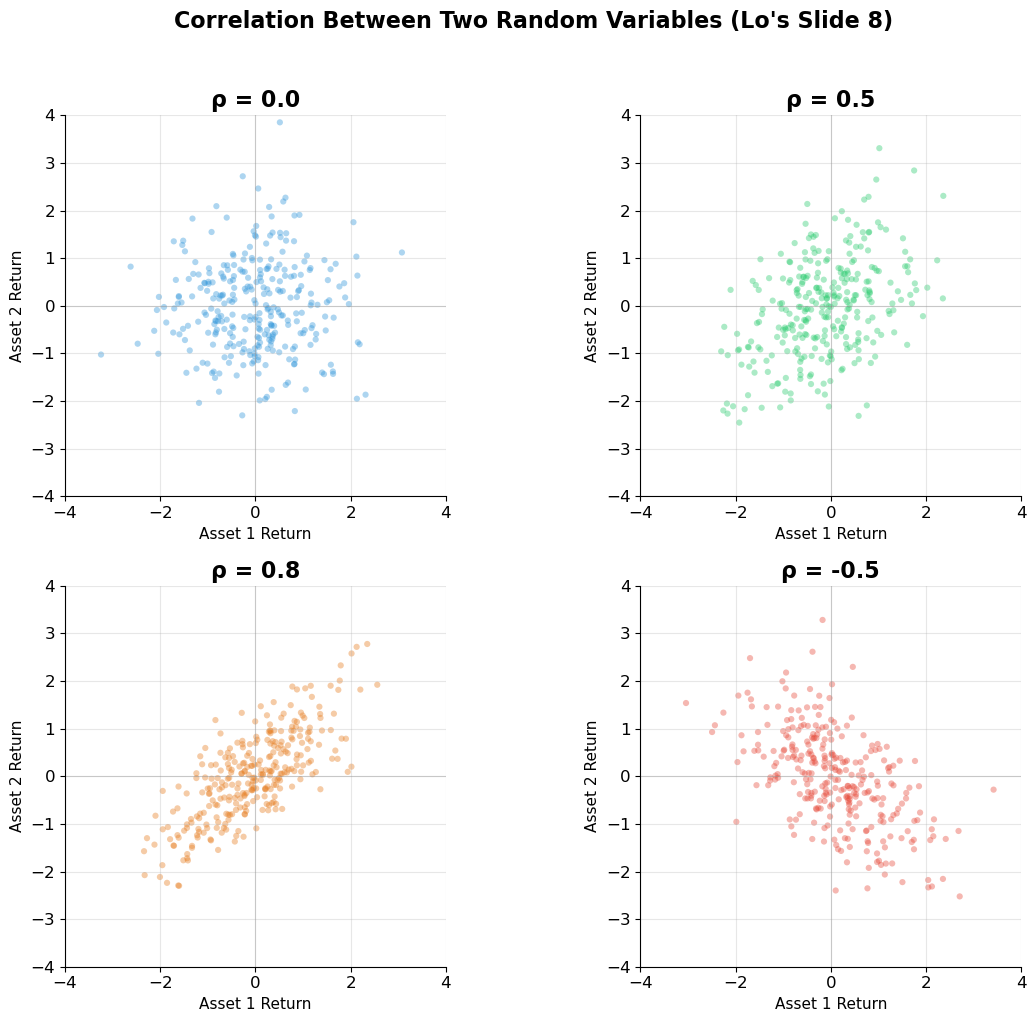

Correlation (ρ) measures the LINEAR co-movement of two variables:
  ρ = +1:  perfect positive correlation (move in lockstep)
  ρ =  0:  no linear relationship (independent if jointly normal)
  ρ = -1:  perfect negative correlation (one goes up, other goes down)

Crucial for portfolio theory: when ρ < 1, diversification reduces risk!


In [8]:
# ============================================================
# Correlation — Visual Explanation (Lo's Slide 8)
# ============================================================
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
correlations = [0.0, 0.5, 0.8, -0.5]
colors = ['#3498db', '#2ecc71', '#e67e22', '#e74c3c']
n_pts = 300

for ax, rho, color in zip(axes.flat, correlations, colors):
    # Generate correlated normal random variables
    mean = [0, 0]
    cov = [[1, rho], [rho, 1]]
    x, y = np.random.multivariate_normal(mean, cov, n_pts).T
    
    ax.scatter(x, y, alpha=0.4, s=20, color=color, edgecolor='none')
    ax.set_xlim(-4, 4)
    ax.set_ylim(-4, 4)
    ax.axhline(y=0, color='gray', linewidth=0.8, alpha=0.3)
    ax.axvline(x=0, color='gray', linewidth=0.8, alpha=0.3)
    ax.set_title(f'ρ = {rho}', fontsize=16, fontweight='bold')
    ax.set_xlabel('Asset 1 Return', fontsize=11)
    ax.set_ylabel('Asset 2 Return', fontsize=11)
    ax.set_aspect('equal')

plt.suptitle("Correlation Between Two Random Variables (Lo's Slide 8)", 
             fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

print("Correlation (ρ) measures the LINEAR co-movement of two variables:")
print("  ρ = +1:  perfect positive correlation (move in lockstep)")
print("  ρ =  0:  no linear relationship (independent if jointly normal)")
print("  ρ = -1:  perfect negative correlation (one goes up, other goes down)")
print("\nCrucial for portfolio theory: when ρ < 1, diversification reduces risk!")

INVESTOR PREFERENCES — Wang Lecture Notes Example
     Asset       Mean      StDev       Skew       Kurt
-------------------------------------------------------
   Asset 0      7.98%     10.03%      0.002      0.026
   Asset 1     12.14%     10.01%     -0.008      0.076
   Asset 2     11.69%     24.78%      0.008     -0.086

Investor preference ranking:
  Asset 1 vs Asset 0: Same risk, higher return → Asset 1 dominates
  Asset 1 vs Asset 2: Same return, lower risk  → Asset 1 dominates
  Asset 0 vs Asset 2: Lower return AND higher risk → Asset 2 not necessarily worse
                      (higher risk is compensated by higher return)


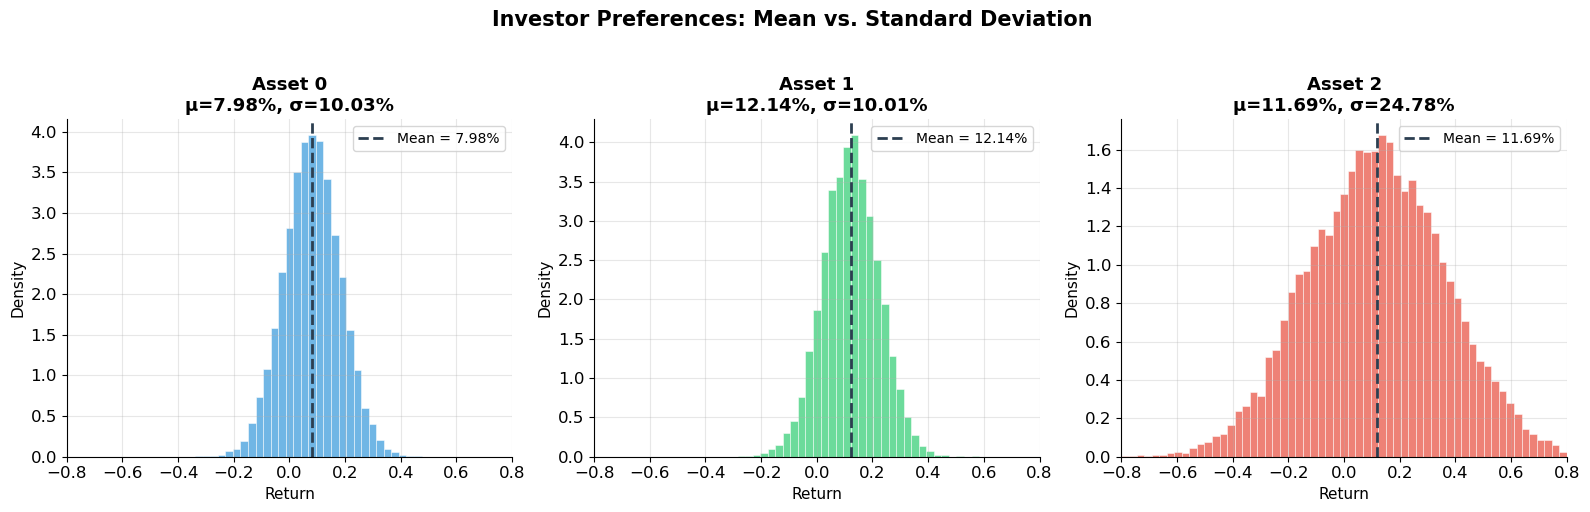

In [9]:
# ============================================================
# Example: Moments of Return Distributions (Wang Lecture Notes)
# ============================================================
# Three hypothetical assets to illustrate investor preferences
np.random.seed(42)
n = 10000

# Asset 0: low mean, low risk
r0 = np.random.normal(0.08, 0.10, n)
# Asset 1: high mean, low risk (dominates Asset 0)
r1 = np.random.normal(0.12, 0.10, n)
# Asset 2: high mean, high risk
r2 = np.random.normal(0.12, 0.25, n)

assets = {'Asset 0': r0, 'Asset 1': r1, 'Asset 2': r2}

print("=" * 65)
print("INVESTOR PREFERENCES — Wang Lecture Notes Example")
print("=" * 65)
print(f"{'Asset':>10s} {'Mean':>10s} {'StDev':>10s} {'Skew':>10s} {'Kurt':>10s}")
print("-" * 55)
for name, r in assets.items():
    print(f"{name:>10s} {r.mean():>10.2%} {r.std():>10.2%} {skew(r):>10.3f} {kurtosis(r):>10.3f}")

print(f"\nInvestor preference ranking:")
print(f"  Asset 1 vs Asset 0: Same risk, higher return → Asset 1 dominates")
print(f"  Asset 1 vs Asset 2: Same return, lower risk  → Asset 1 dominates")
print(f"  Asset 0 vs Asset 2: Lower return AND higher risk → Asset 2 not necessarily worse")
print(f"                      (higher risk is compensated by higher return)")

fig, axes = plt.subplots(1, 3, figsize=(16, 5))
colors = ['#3498db', '#2ecc71', '#e74c3c']
bins = np.linspace(-0.8, 0.8, 60)

for ax, (name, r), color in zip(axes, assets.items(), colors):
    ax.hist(r, bins=bins, color=color, alpha=0.7, density=True, edgecolor='white', linewidth=0.5)
    ax.axvline(x=r.mean(), color='#2c3e50', linewidth=2, linestyle='--', label=f'Mean = {r.mean():.2%}')
    ax.set_xlabel('Return', fontsize=11)
    ax.set_ylabel('Density', fontsize=11)
    ax.set_title(f'{name}\nμ={r.mean():.2%}, σ={r.std():.2%}', fontsize=13, fontweight='bold')
    ax.legend(fontsize=10)
    ax.set_xlim(-0.8, 0.8)

plt.suptitle('Investor Preferences: Mean vs. Standard Deviation', fontsize=15, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

---

<a id='3-empirical'></a>
## 3. Empirical Properties of U.S. Stock Returns

### Lo's Four Facts (Slide 14)

From the history of U.S. financial markets (1926–2001):

1. **Real interest rate has been slightly positive on average.**
2. **Returns on riskier assets have been higher on average** than returns on less risky assets.
3. **Returns on risky assets can be highly correlated** with each other.
4. **Returns on risky assets are (usually) serially uncorrelated** — knowing this month's return tells you almost nothing about next month's.

### Lo's Summary Statistics (Slide 14)

Basic statistics, U.S. markets, 1946–2001 (monthly, in percent):

| Series | Mean | Std Dev | Skew | Min | Max |
|--------|------|---------|------|-----|-----|
| Inflation (CPI) | 0.32% | 0.36% | 0.82 | -0.84% | 1.85% |
| T-bill (1 yr) | 0.38% | 0.24% | 0.98 | 0.03% | 1.34% |
| T-note (10 yr) | 0.46% | 2.63% | 0.61 | -7.73% | 13.31% |
| VW Stock Index | 1.01% | 4.23% | -0.47 | -22.49% | 16.56% |
| EW Stock Index | 1.18% | 5.30% | -0.17 | -27.09% | 29.92% |
| Motorola | 1.66% | 10.02% | 0.01 | -33.49% | 41.67% |

### Key Observations from Lo's Slide 33

- Average annual stock return (1926–2004): **11.2%**, with an average risk premium of **7.8%**
- Market monthly standard deviation: **4.5%** (≈ 16.4% annualized)
- Individual stock monthly standard deviation: **~17%** (≈ 50% annualized) — much riskier than the market!
- Stock returns are **nearly unpredictable** on a month-to-month basis
- Market volatility **changes over time** (standard deviation ranges from ~2% to ~20% monthly)

In [11]:
# ============================================================
# Lo's Summary Statistics — Simulated Reproduction
# ============================================================
# Reproduce Lo's table with the exact values from Slide 14
lo_data = pd.DataFrame({
    'Series': ['Inflation (CPI)', 'T-bill (1yr)', 'T-note (10yr)', 
               'VW Stock Index', 'EW Stock Index', 'Motorola'],
    'Mean (%)': [0.32, 0.38, 0.46, 1.01, 1.18, 1.66],
    'StDev (%)': [0.36, 0.24, 2.63, 4.23, 5.30, 10.02],
    'Skew': [0.82, 0.98, 0.61, -0.47, -0.17, 0.01],
    'Min (%)': [-0.84, 0.03, -7.73, -22.49, -27.09, -33.49],
    'Max (%)': [1.85, 1.34, 13.31, 16.56, 29.92, 41.67],
})

# Annualize
lo_data['Ann. Mean (%)'] = lo_data['Mean (%)'] * 12
lo_data['Ann. StDev (%)'] = lo_data['StDev (%)'] * np.sqrt(12)

print("=" * 80)
print("LO'S SUMMARY STATISTICS — U.S. Financial Markets, 1946-2001 (Monthly)")
print("=" * 80)
print(lo_data[['Series', 'Mean (%)', 'StDev (%)', 'Skew', 'Min (%)', 'Max (%)']].to_string(index=False))

print("\nAnnualized (approximate):")
print(f"{'Series':>20s} {'Ann Mean':>10s} {'Ann StDev':>10s}")
print("-" * 45)
for _, row in lo_data.iterrows():
    print(f"{row['Series']:>20s} {row['Ann. Mean (%)']:>9.1f}% {row['Ann. StDev (%)']:>9.1f}%")

print("\nKey insight: RISK-RETURN TRADEOFF")
print("Higher average return comes with higher volatility:")
print("  T-bill:    0.38% monthly return,  0.24% monthly StDev → almost risk-free")
print("  VW Market: 1.01% monthly return,  4.23% monthly StDev → significant risk")
print("  Motorola:  1.66% monthly return, 10.02% monthly StDev → much more risk")
print("  \n→ But individual stocks (Motorola) are MUCH riskier than the market")
print("  → This gap is the diversification effect (Session 10)")

LO'S SUMMARY STATISTICS — U.S. Financial Markets, 1946-2001 (Monthly)
         Series  Mean (%)  StDev (%)  Skew  Min (%)  Max (%)
Inflation (CPI)      0.32       0.36  0.82    -0.84     1.85
   T-bill (1yr)      0.38       0.24  0.98     0.03     1.34
  T-note (10yr)      0.46       2.63  0.61    -7.73    13.31
 VW Stock Index      1.01       4.23 -0.47   -22.49    16.56
 EW Stock Index      1.18       5.30 -0.17   -27.09    29.92
       Motorola      1.66      10.02  0.01   -33.49    41.67

Annualized (approximate):
              Series   Ann Mean  Ann StDev
---------------------------------------------
     Inflation (CPI)       3.8%       1.2%
        T-bill (1yr)       4.6%       0.8%
       T-note (10yr)       5.5%       9.1%
      VW Stock Index      12.1%      14.7%
      EW Stock Index      14.2%      18.4%
            Motorola      19.9%      34.7%

Key insight: RISK-RETURN TRADEOFF
Higher average return comes with higher volatility:
  T-bill:    0.38% monthly return,  0.24% 

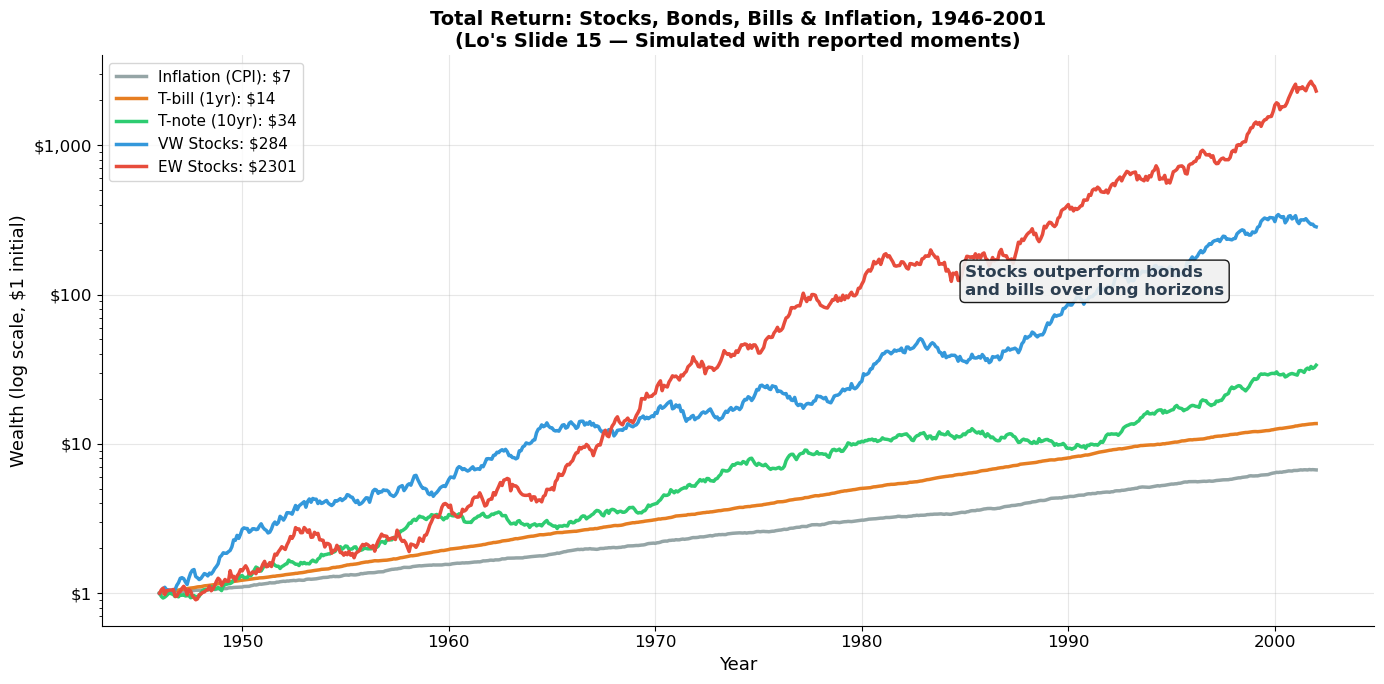

The equity premium is one of the most important facts in finance:
  VW Stock monthly return:  1.01% → 12.1% annualized
  T-bill monthly return:    0.38% → 4.6% annualized
  Equity premium:           7.6% per year

Over 56 years, this compounds to enormous wealth differences.


In [12]:
# ============================================================
# Wealth Accumulation: Stocks, Bonds, Bills, Inflation (Lo's Slide 15)
# ============================================================
# Simulate total return indices from Lo's reported monthly statistics
months = np.arange(0, 56*12 + 1)  # 1946-2001

# Use Lo's monthly mean returns to build wealth paths
monthly_means = {
    'Inflation (CPI)':  0.0032,
    'T-bill (1yr)':     0.0038,
    'T-note (10yr)':    0.0046,
    'VW Stocks':        0.0101,
    'EW Stocks':        0.0118,
}
monthly_stds = {
    'Inflation (CPI)':  0.0036,
    'T-bill (1yr)':     0.0024,
    'T-note (10yr)':    0.0263,
    'VW Stocks':        0.0423,
    'EW Stocks':        0.0530,
}

np.random.seed(2008)

fig, ax = plt.subplots(figsize=(14, 7))
colors = {'Inflation (CPI)': '#95a5a6', 'T-bill (1yr)': '#e67e22', 
          'T-note (10yr)': '#2ecc71', 'VW Stocks': '#3498db', 'EW Stocks': '#e74c3c'}

for name in monthly_means:
    # Generate simulated returns with correct moments
    T = 56 * 12
    returns = np.random.normal(monthly_means[name], monthly_stds[name], T)
    wealth = np.ones(T + 1)
    for t in range(T):
        wealth[t + 1] = wealth[t] * (1 + returns[t])
    
    years = np.linspace(1946, 2002, T + 1)
    ax.semilogy(years, wealth, color=colors[name], linewidth=2.5, label=f'{name}: ${wealth[-1]:.0f}')

ax.set_xlabel('Year', fontsize=13)
ax.set_ylabel('Wealth (log scale, $1 initial)', fontsize=13)
ax.set_title('Total Return: Stocks, Bonds, Bills & Inflation, 1946-2001\n(Lo\'s Slide 15 — Simulated with reported moments)',
            fontsize=14, fontweight='bold')
ax.legend(fontsize=11, loc='upper left')
ax.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'${x:,.0f}' if x >= 1 else f'${x:.2f}'))

ax.annotate('Stocks outperform bonds\nand bills over long horizons', xy=(1985, 100),
           fontsize=12, fontweight='bold', color='#2c3e50',
           bbox=dict(boxstyle='round', facecolor='#f0f0f0', alpha=0.9))

plt.tight_layout()
plt.show()

print("The equity premium is one of the most important facts in finance:")
print(f"  VW Stock monthly return:  {0.0101:.2%} → {0.0101*12:.1%} annualized")
print(f"  T-bill monthly return:    {0.0038:.2%} → {0.0038*12:.1%} annualized")
print(f"  Equity premium:           {(0.0101-0.0038)*12:.1%} per year")
print(f"\nOver 56 years, this compounds to enormous wealth differences.")

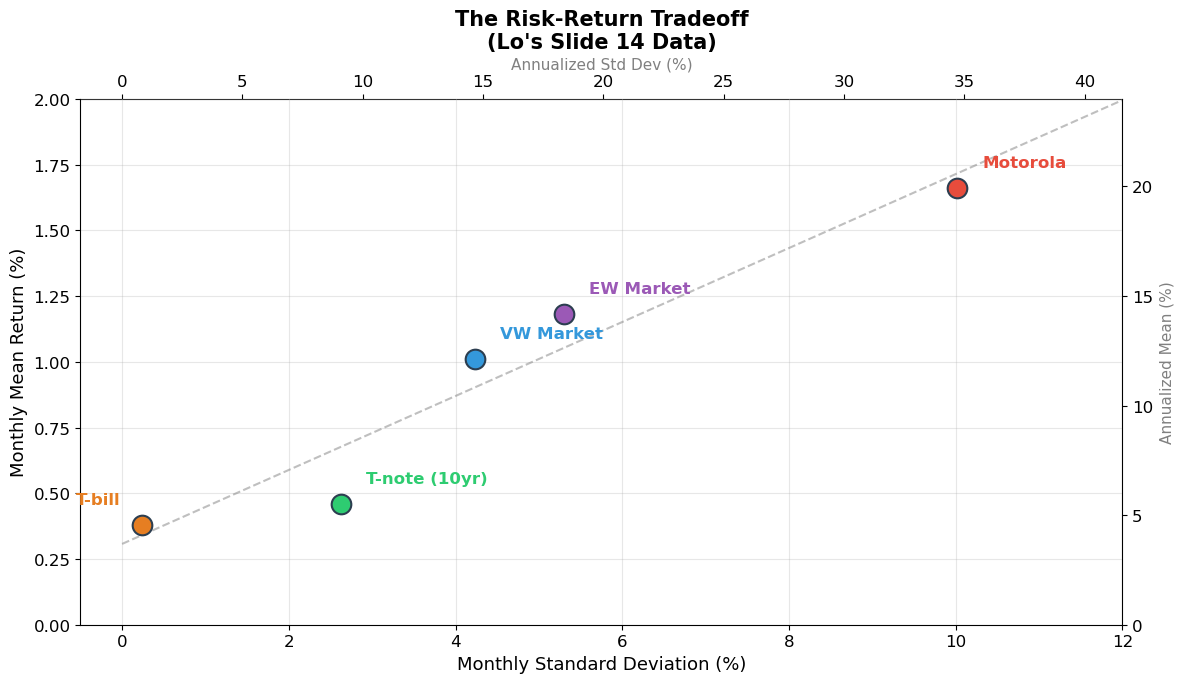

Key insight: Higher risk (standard deviation) → Higher average return
This is the risk-return tradeoff — the foundation of asset pricing.

But notice: Motorola has ~2.4× the StDev of the VW market
  yet only ~1.6× the return. Individual stock risk is not efficiently
  rewarded because much of it is diversifiable (Session 10).


In [13]:
# ============================================================
# Risk-Return Tradeoff Visualization
# ============================================================
fig, ax = plt.subplots(figsize=(12, 7))

# Lo's data: monthly mean and stdev
assets = [
    ('T-bill', 0.38, 0.24, '#e67e22'),
    ('T-note (10yr)', 0.46, 2.63, '#2ecc71'),
    ('VW Market', 1.01, 4.23, '#3498db'),
    ('EW Market', 1.18, 5.30, '#9b59b6'),
    ('Motorola', 1.66, 10.02, '#e74c3c'),
]

for name, mean, std, color in assets:
    ax.scatter(std, mean, s=200, color=color, zorder=5, edgecolor='#2c3e50', linewidth=1.5)
    offset_x = 0.3 if name != 'T-bill' else -0.8
    offset_y = 0.08
    ax.annotate(name, xy=(std, mean), xytext=(std + offset_x, mean + offset_y),
               fontsize=12, fontweight='bold', color=color)

# Annualized axis
ax2_y = ax.secondary_yaxis('right', functions=(lambda y: y*12, lambda y: y/12))
ax2_x = ax.secondary_xaxis('top', functions=(lambda x: x*np.sqrt(12), lambda x: x/np.sqrt(12)))
ax2_y.set_ylabel('Annualized Mean (%)', fontsize=11, color='gray')
ax2_x.set_xlabel('Annualized Std Dev (%)', fontsize=11, color='gray')

ax.set_xlabel('Monthly Standard Deviation (%)', fontsize=13)
ax.set_ylabel('Monthly Mean Return (%)', fontsize=13)
ax.set_title('The Risk-Return Tradeoff\n(Lo\'s Slide 14 Data)', fontsize=15, fontweight='bold')

# Trend line
stds = [a[2] for a in assets]
means = [a[1] for a in assets]
z = np.polyfit(stds, means, 1)
x_line = np.linspace(0, 12, 100)
ax.plot(x_line, np.polyval(z, x_line), color='gray', linewidth=1.5, linestyle='--', alpha=0.5)

ax.set_xlim(-0.5, 12)
ax.set_ylim(0, 2.0)

plt.tight_layout()
plt.show()

print("Key insight: Higher risk (standard deviation) → Higher average return")
print("This is the risk-return tradeoff — the foundation of asset pricing.")
print("\nBut notice: Motorola has ~2.4× the StDev of the VW market")
print("  yet only ~1.6× the return. Individual stock risk is not efficiently")
print("  rewarded because much of it is diversifiable (Session 10).")

---

<a id='4-random-walk'></a>
## 4. The Random Walk and Market Efficiency

### Are Returns Predictable? (Lo's Slides 12–13, 20–22)

Lo presents two contrasting price patterns:

**Predictable price changes** (Slide 12): A smooth, trending path where tomorrow's return can be forecast from today's. In an efficient market, this cannot persist — investors would exploit the pattern until it disappears.

**Random walk with drift** (Slide 13): Price changes are unpredictable. The drift $\mu$ gives the expected return, but day-to-day movements are random. This is the baseline model for efficient markets.

### Empirical Evidence: Serial Correlation

Lo's scatterplots (Slides 20–22) are striking:

- **Today vs. yesterday (VWRETD, 1980–1999):** essentially a circular cloud — no pattern.
- **This month vs. last month (S&P 500, 1926–1997):** again, a blob — nearly zero serial correlation.
- **GM vs. S&P 500:** positive correlation (~0.5), as expected for co-movement with the market.

The takeaway: **stock returns are nearly serially uncorrelated**. Knowing today's return tells you virtually nothing about tomorrow's. This is consistent with market efficiency.

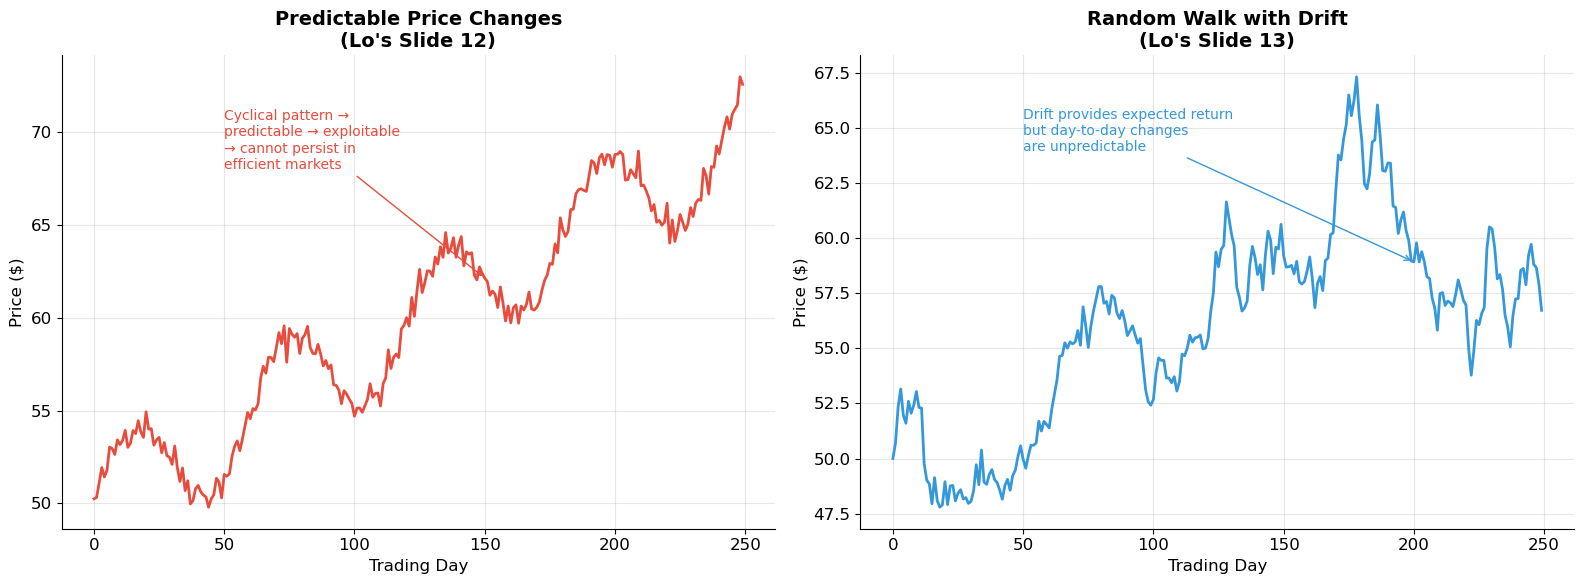

In efficient markets, prices should follow a random walk (possibly with drift).
If prices were predictable, investors would trade on the pattern until it vanished.


In [15]:
# ============================================================
# Random Walk vs. Predictable Prices (Lo's Slides 12-13)
# ============================================================
np.random.seed(42)
T = 250  # trading days

# Predictable: trending with mean reversion
t = np.arange(T)
predictable = 50 + 0.08 * t + 3 * np.sin(2 * np.pi * t / 60) + np.random.normal(0, 0.5, T)

# Random walk with drift
drift = 0.0003  # daily drift
sigma_daily = 0.015
shocks = np.random.normal(drift, sigma_daily, T)
random_walk = np.zeros(T)
random_walk[0] = 50
for i in range(1, T):
    random_walk[i] = random_walk[i-1] * (1 + shocks[i])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

ax1.plot(t, predictable, color='#e74c3c', linewidth=2)
ax1.set_xlabel('Trading Day', fontsize=12)
ax1.set_ylabel('Price ($)', fontsize=12)
ax1.set_title('Predictable Price Changes\n(Lo\'s Slide 12)', fontsize=14, fontweight='bold')
ax1.annotate('Cyclical pattern →\npredictable → exploitable\n→ cannot persist in\nefficient markets', 
            xy=(150, predictable[150]), xytext=(50, 68),
            fontsize=10, color='#e74c3c',
            arrowprops=dict(arrowstyle='->', color='#e74c3c'))

ax2.plot(t, random_walk, color='#3498db', linewidth=2)
ax2.set_xlabel('Trading Day', fontsize=12)
ax2.set_ylabel('Price ($)', fontsize=12)
ax2.set_title('Random Walk with Drift\n(Lo\'s Slide 13)', fontsize=14, fontweight='bold')
ax2.annotate('Drift provides expected return\nbut day-to-day changes\nare unpredictable', 
            xy=(200, random_walk[200]), xytext=(50, random_walk.max() * 0.95),
            fontsize=10, color='#3498db',
            arrowprops=dict(arrowstyle='->', color='#3498db'))

plt.tight_layout()
plt.show()

print("In efficient markets, prices should follow a random walk (possibly with drift).")
print("If prices were predictable, investors would trade on the pattern until it vanished.")

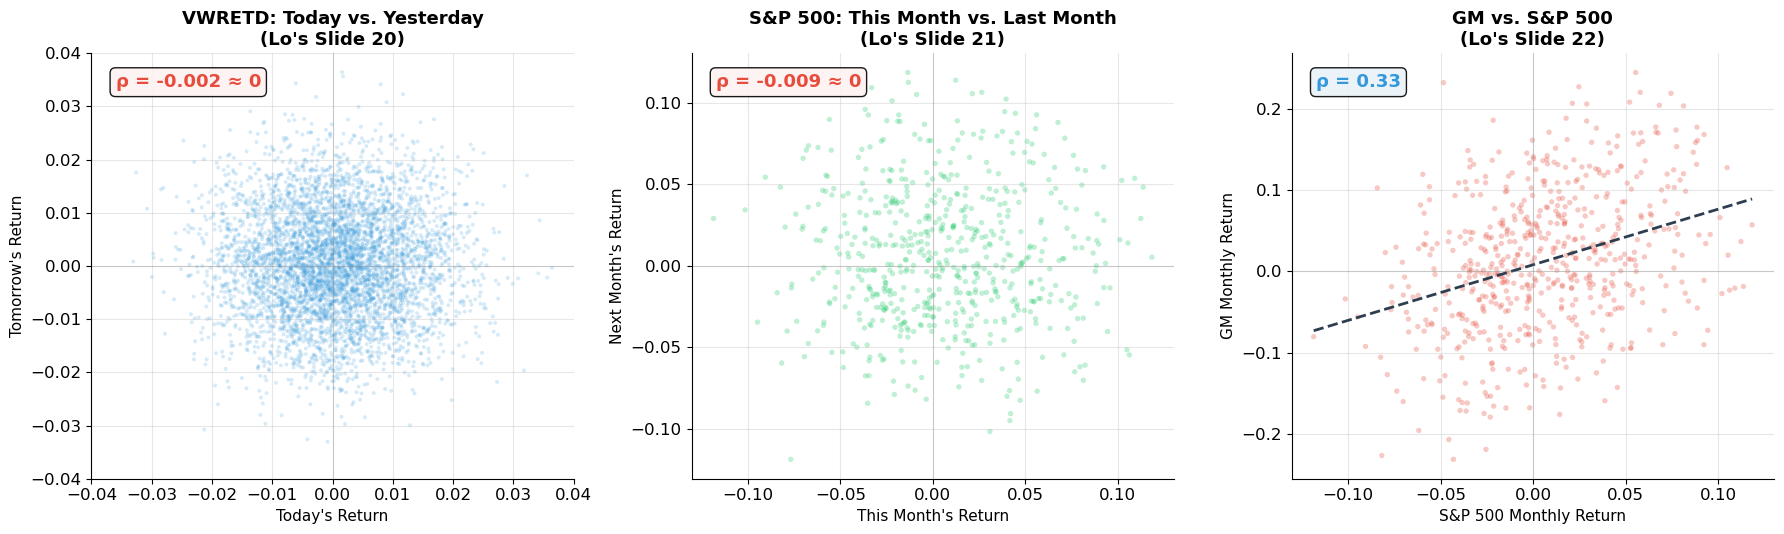

Serial correlation (autocorrelation):
  Daily: ρ ≈ -0.002 — returns are essentially unpredictable
  Monthly: ρ ≈ -0.009 — same result at monthly frequency

Cross-sectional correlation:
  GM vs. S&P 500: ρ ≈ 0.33 — stocks move with the market (beta effect)
  Regression slope (≈ beta): 0.69

→ Returns are unpredictable over time, but correlated across stocks


In [16]:
# ============================================================
# Serial Correlation of Returns (Lo's Slides 20-22)
# ============================================================
np.random.seed(2008)

# Simulate market returns with realistic statistics
n_months = 600  # ~50 years
market_returns = np.random.normal(0.01, 0.0423, n_months)

# GM returns correlated with market
rho_gm_mkt = 0.6
gm_idio = np.random.normal(0.005, 0.085, n_months)
gm_returns = 0.7 * market_returns + gm_idio

fig, axes = plt.subplots(1, 3, figsize=(18, 5.5))

# Plot 1: Today vs Yesterday (daily-like)
daily_returns = np.random.normal(0.0004, 0.01, 5000)
axes[0].scatter(daily_returns[:-1], daily_returns[1:], alpha=0.2, s=8, color='#3498db', edgecolor='none')
axes[0].set_xlabel("Today's Return", fontsize=11)
axes[0].set_ylabel("Tomorrow's Return", fontsize=11)
axes[0].set_title("VWRETD: Today vs. Yesterday\n(Lo's Slide 20)", fontsize=13, fontweight='bold')
axes[0].set_xlim(-0.04, 0.04)
axes[0].set_ylim(-0.04, 0.04)
rho_serial = np.corrcoef(daily_returns[:-1], daily_returns[1:])[0, 1]
axes[0].text(0.05, 0.92, f'ρ = {rho_serial:.3f} ≈ 0', transform=axes[0].transAxes,
            fontsize=13, fontweight='bold', color='#e74c3c',
            bbox=dict(boxstyle='round', facecolor='#fdf2f2', alpha=0.9))
axes[0].axhline(y=0, color='gray', linewidth=0.8, alpha=0.3)
axes[0].axvline(x=0, color='gray', linewidth=0.8, alpha=0.3)

# Plot 2: This month vs Last month
axes[1].scatter(market_returns[:-1], market_returns[1:], alpha=0.3, s=15, color='#2ecc71', edgecolor='none')
axes[1].set_xlabel("This Month's Return", fontsize=11)
axes[1].set_ylabel("Next Month's Return", fontsize=11)
axes[1].set_title("S&P 500: This Month vs. Last Month\n(Lo's Slide 21)", fontsize=13, fontweight='bold')
rho_monthly = np.corrcoef(market_returns[:-1], market_returns[1:])[0, 1]
axes[1].text(0.05, 0.92, f'ρ = {rho_monthly:.3f} ≈ 0', transform=axes[1].transAxes,
            fontsize=13, fontweight='bold', color='#e74c3c',
            bbox=dict(boxstyle='round', facecolor='#fdf2f2', alpha=0.9))
axes[1].axhline(y=0, color='gray', linewidth=0.8, alpha=0.3)
axes[1].axvline(x=0, color='gray', linewidth=0.8, alpha=0.3)

# Plot 3: GM vs S&P 500
axes[2].scatter(market_returns, gm_returns, alpha=0.3, s=15, color='#e74c3c', edgecolor='none')
axes[2].set_xlabel("S&P 500 Monthly Return", fontsize=11)
axes[2].set_ylabel("GM Monthly Return", fontsize=11)
axes[2].set_title("GM vs. S&P 500\n(Lo's Slide 22)", fontsize=13, fontweight='bold')
rho_cross = np.corrcoef(market_returns, gm_returns)[0, 1]
axes[2].text(0.05, 0.92, f'ρ = {rho_cross:.2f}', transform=axes[2].transAxes,
            fontsize=13, fontweight='bold', color='#3498db',
            bbox=dict(boxstyle='round', facecolor='#eaf2f8', alpha=0.9))
# Add regression line
slope, intercept = np.polyfit(market_returns, gm_returns, 1)
x_fit = np.linspace(market_returns.min(), market_returns.max(), 100)
axes[2].plot(x_fit, slope * x_fit + intercept, color='#2c3e50', linewidth=2, linestyle='--')
axes[2].axhline(y=0, color='gray', linewidth=0.8, alpha=0.3)
axes[2].axvline(x=0, color='gray', linewidth=0.8, alpha=0.3)

plt.tight_layout()
plt.show()

print("Serial correlation (autocorrelation):")
print(f"  Daily: ρ ≈ {rho_serial:.3f} — returns are essentially unpredictable")
print(f"  Monthly: ρ ≈ {rho_monthly:.3f} — same result at monthly frequency")
print(f"\nCross-sectional correlation:")
print(f"  GM vs. S&P 500: ρ ≈ {rho_cross:.2f} — stocks move with the market (beta effect)")
print(f"  Regression slope (≈ beta): {slope:.2f}")
print(f"\n→ Returns are unpredictable over time, but correlated across stocks")

---

<a id='5-volatility'></a>
## 5. Time-Varying Volatility

### Volatility Clustering (Lo's Slide 23)

One of the most important empirical facts about stock returns is that **volatility is not constant** — it changes over time, and it tends to **cluster**: periods of high volatility are followed by more high volatility, and calm periods persist.

Lo's Slide 23 shows monthly estimates of daily volatility for the U.S. stock market from 1926 to 1997. Key features:
- The Great Depression (1929–1933): volatility spiked to ~6% daily
- The post-war period (1946–1960s): relatively calm, ~1% daily
- The 1970s oil crises: elevated volatility
- October 1987 (Black Monday): massive volatility spike
- Volatility ranges from roughly 0.5% to 6% daily

This has profound implications:
1. **Risk is time-varying** — a single estimate of $\sigma$ may be misleading
2. **GARCH models** capture this clustering (autocorrelation in squared returns)
3. **Option prices** change with volatility (vega risk from Session 8)

C:\Users\mjfmourey\AppData\Local\Temp\ipykernel_17352\727678642.py:59: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout()


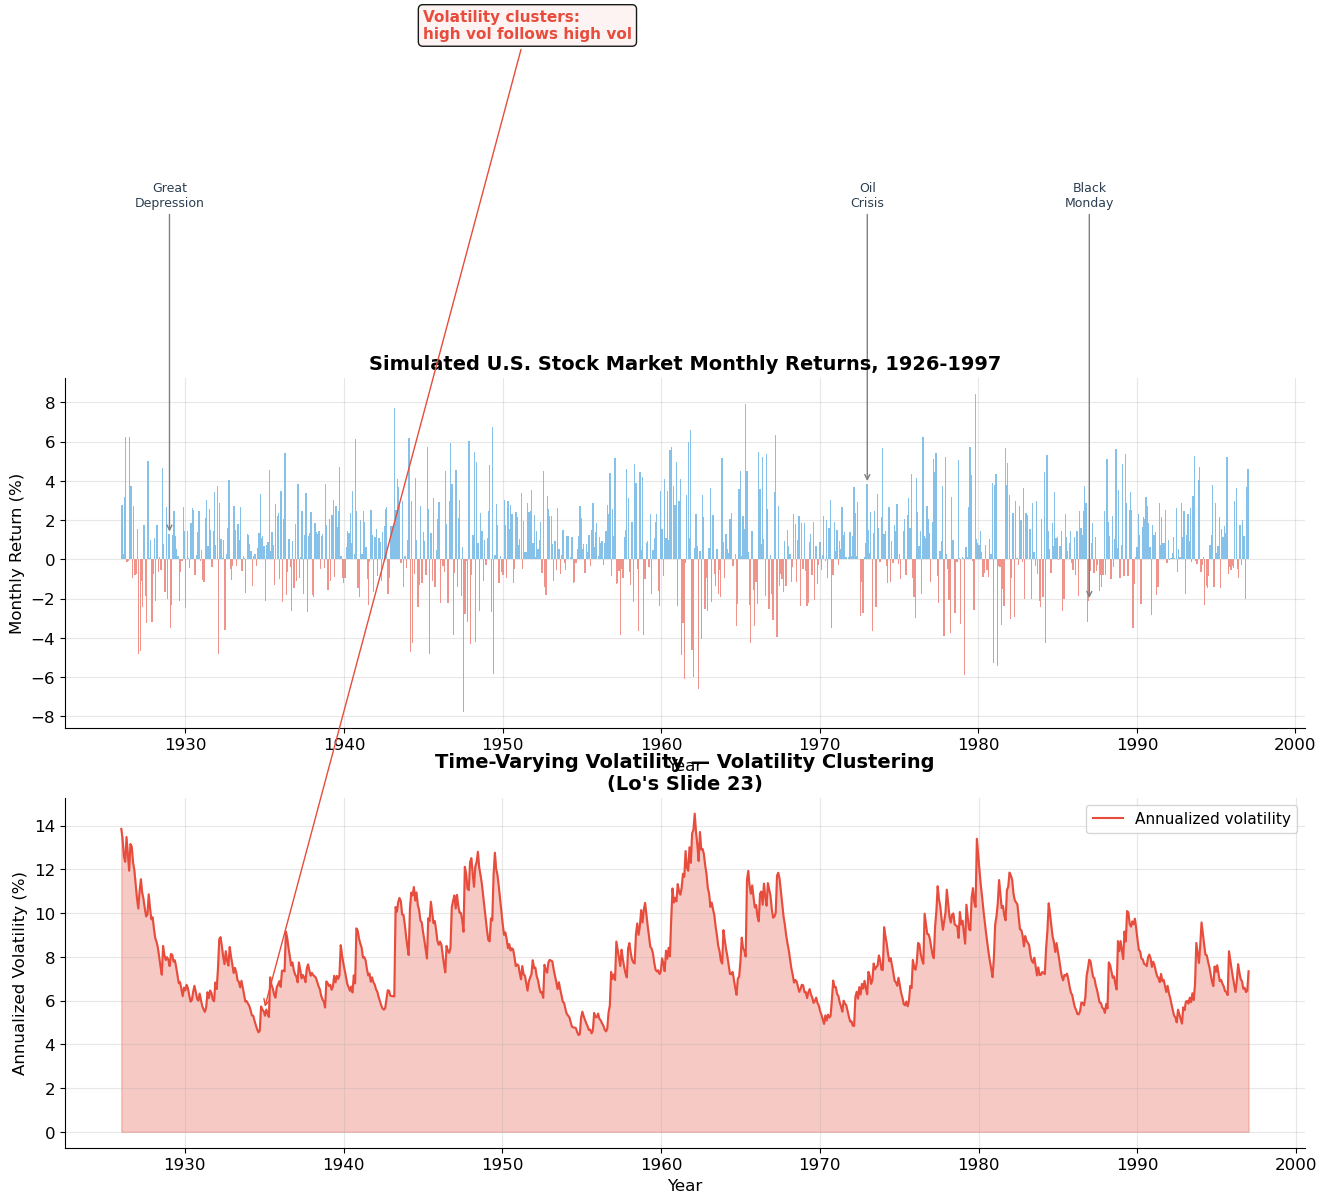

Autocorrelation of returns:         ρ(Rₜ, Rₜ₋₁) = -0.0244 ≈ 0
Autocorrelation of squared returns: ρ(Rₜ², Rₜ₋₁²) = 0.1154 >> 0

→ Returns are unpredictable, but VOLATILITY is predictable!
  This is the essence of GARCH: σ²ₜ = ω + α·R²ₜ₋₁ + β·σ²ₜ₋₁


In [18]:
# ============================================================
# Time-Varying Volatility (Lo's Slide 23)
# ============================================================
np.random.seed(42)
n_months = 72 * 12  # 1926-1997 = ~72 years

# Simulate GARCH-like volatility clustering
sigma = np.zeros(n_months)
sigma[0] = 0.04  # initial monthly vol
returns = np.zeros(n_months)
omega, alpha, beta = 0.000008, 0.10, 0.88  # GARCH(1,1) params

for t in range(n_months):
    if t > 0:
        sigma[t] = np.sqrt(omega + alpha * returns[t-1]**2 + beta * sigma[t-1]**2)
    returns[t] = np.random.normal(0.008, sigma[t])

# Estimate rolling 21-day (monthly) volatility
# We'll use |returns| as a proxy for daily vol estimates (like Lo's slide)
# Convert to "daily volatility estimates" by dividing monthly by sqrt(21)
daily_vol_est = np.abs(returns) / np.sqrt(21) * 100  # convert to %

# Smooth with rolling window
window = 12
rolling_vol = pd.Series(np.abs(returns)).rolling(window).std() * np.sqrt(12) * 100

years = np.linspace(1926, 1997, n_months)

fig, axes = plt.subplots(2, 1, figsize=(16, 10))

# Top: Returns
axes[0].bar(years, returns * 100, width=0.08, color=np.where(returns >= 0, '#3498db', '#e74c3c'), 
           alpha=0.6, edgecolor='none')
axes[0].set_xlabel('Year', fontsize=12)
axes[0].set_ylabel('Monthly Return (%)', fontsize=12)
axes[0].set_title('Simulated U.S. Stock Market Monthly Returns, 1926-1997', fontsize=14, fontweight='bold')

# Annotations for major events
events = [(1929, 'Great\nDepression'), (1973, 'Oil\nCrisis'), (1987, 'Black\nMonday')]
for yr, label in events:
    idx = int((yr - 1926) / 71 * (n_months - 1))
    axes[0].annotate(label, xy=(yr, returns[idx]*100), xytext=(yr, 18),
                    fontsize=9, ha='center', color='#2c3e50',
                    arrowprops=dict(arrowstyle='->', color='gray', lw=1))

# Bottom: Volatility
axes[1].fill_between(years, 0, sigma * np.sqrt(12) * 100, color='#e74c3c', alpha=0.3)
axes[1].plot(years, sigma * np.sqrt(12) * 100, color='#e74c3c', linewidth=1.5, label='Annualized volatility')
axes[1].set_xlabel('Year', fontsize=12)
axes[1].set_ylabel('Annualized Volatility (%)', fontsize=12)
axes[1].set_title('Time-Varying Volatility — Volatility Clustering\n(Lo\'s Slide 23)', fontsize=14, fontweight='bold')
axes[1].legend(fontsize=11)

axes[1].annotate('Volatility clusters:\nhigh vol follows high vol', xy=(1935, sigma[int(9*12)]*np.sqrt(12)*100),
                xytext=(1945, 50), fontsize=11, color='#e74c3c', fontweight='bold',
                arrowprops=dict(arrowstyle='->', color='#e74c3c'),
                bbox=dict(boxstyle='round', facecolor='#fdf2f2', alpha=0.9))

plt.tight_layout()
plt.show()

# Autocorrelation of squared returns
r2 = returns**2
acf_r = np.corrcoef(returns[1:], returns[:-1])[0, 1]
acf_r2 = np.corrcoef(r2[1:], r2[:-1])[0, 1]
print(f"Autocorrelation of returns:         ρ(Rₜ, Rₜ₋₁) = {acf_r:.4f} ≈ 0")
print(f"Autocorrelation of squared returns: ρ(Rₜ², Rₜ₋₁²) = {acf_r2:.4f} >> 0")
print(f"\n→ Returns are unpredictable, but VOLATILITY is predictable!")
print(f"  This is the essence of GARCH: σ²ₜ = ω + α·R²ₜ₋₁ + β·σ²ₜ₋₁")

---

<a id='6-anomalies'></a>
## 6. Anomalies

Lo devotes slides 24–32 to **anomalies** — empirical patterns in stock returns that are difficult to explain under standard efficient market theory. These have generated enormous academic debate and practical interest.

### Anomaly 1: The Size Effect (Slide 24)

**Finding:** Small-capitalization stocks tend to outperform large-capitalization stocks. When firms are sorted into 10 deciles by market cap (1964–2004), the smallest decile earns ~15% annually vs. ~10% for the largest.

### Anomaly 2: The January Effect (Slide 25)

**Finding:** Returns in January are abnormally high, especially for small stocks. The size premium is heavily concentrated in January. Possible explanations: tax-loss selling in December, window dressing by fund managers.

### Anomaly 3: The Value Premium (Slide 26)

**Finding:** Stocks with low Price/Book ratios ("value stocks") tend to outperform stocks with high P/B ratios ("growth stocks"). Decile 1 (high P/B, "growth") earns ~10% vs. ~17% for Decile 10 (low P/B, "value").

### Anomaly 4: Momentum (Slide 27)

**Finding:** Stocks with high returns over the past 12 months tend to continue outperforming, and past losers continue underperforming. Decile 1 (past losers) earns ~6% vs. ~16% for Decile 10 (past winners).

### Anomaly 5: The Accrual Effect (Slide 28)

**Finding:** Firms with high operating accruals (operating income minus operating cash flows) tend to underperform. Investors may be fooled by the "quality" of earnings.

### Anomaly 6: IPO/SEO Underperformance (Slides 29–30)

**Finding:** Firms that issue equity (IPOs and SEOs) tend to underperform in the 1–5 years following issuance. Possible explanation: managers issue when stock is overvalued.

### The Debate

Are these anomalies:
- **Risk factors** in disguise? (Fama-French: size and value proxy for risk)
- **Behavioral biases?** (Overreaction, underreaction, herd behavior)
- **Data mining?** (Finding patterns after the fact)
- **Transaction costs?** (Profitable on paper, not in practice)

This debate remains one of the central questions in financial economics.

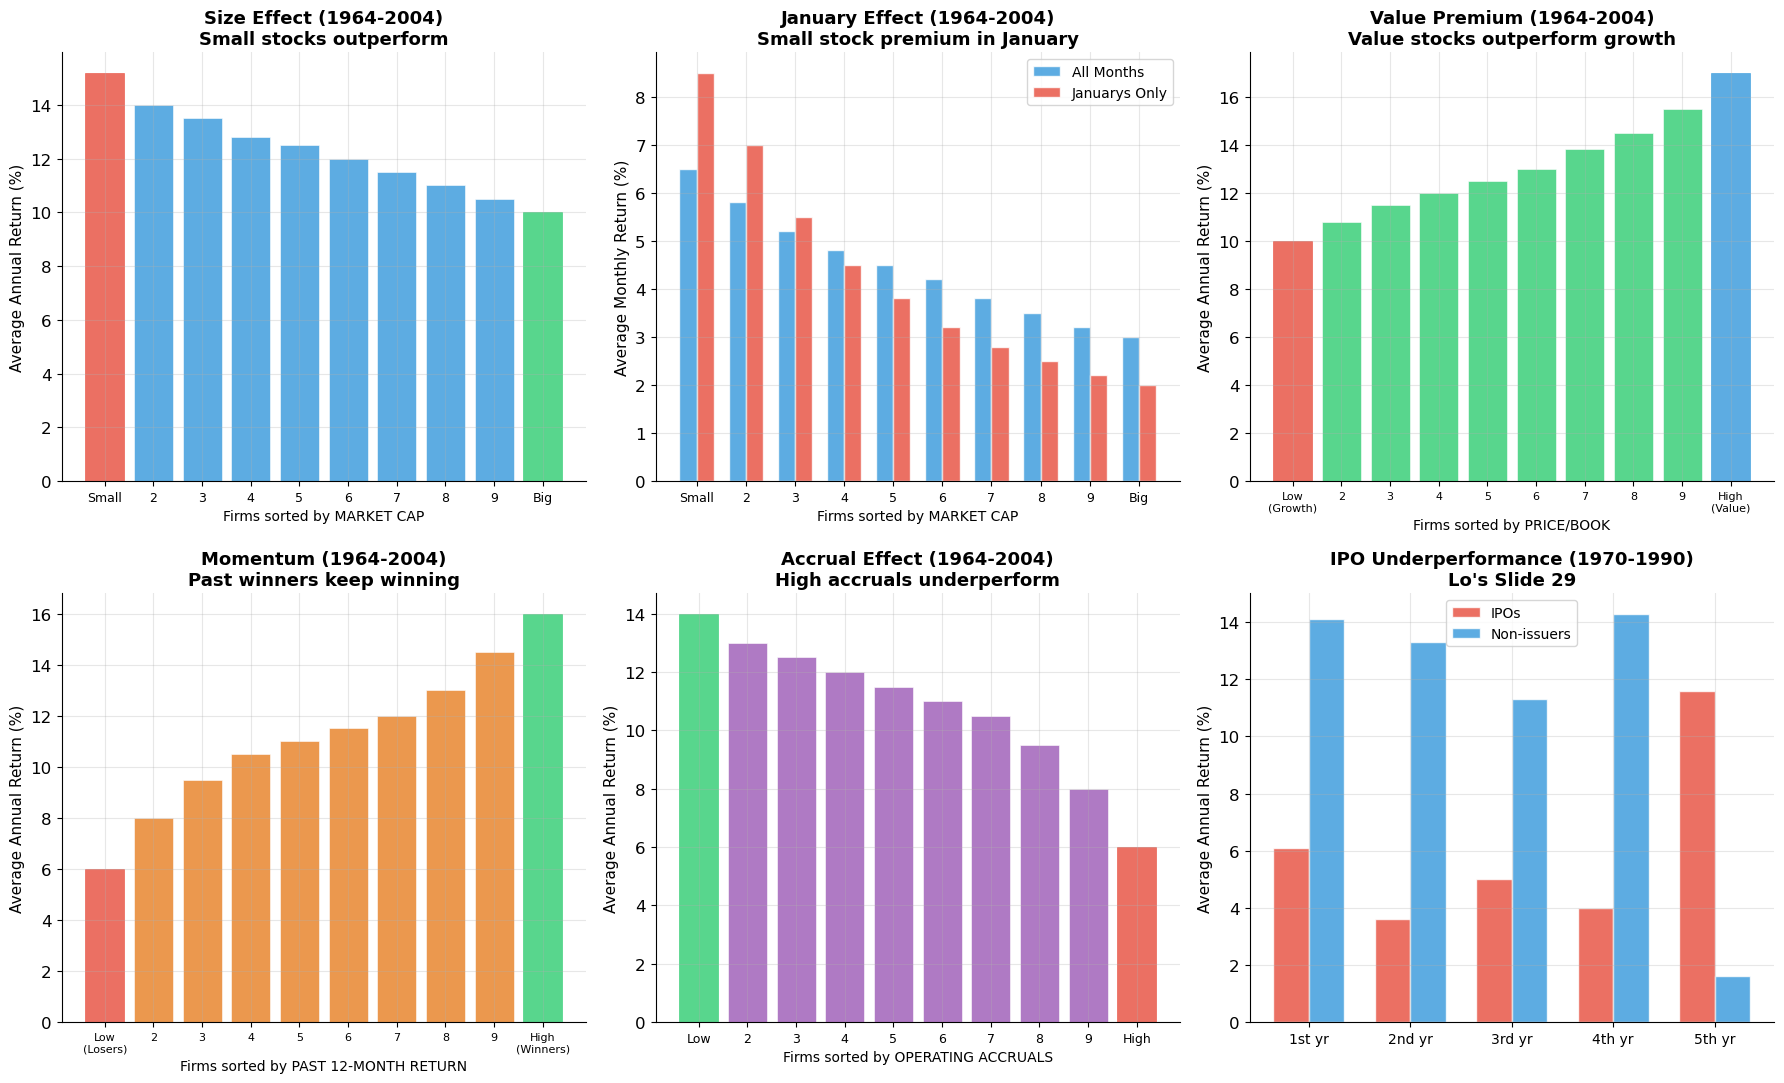

Summary of anomalies:
  Size:     Small stocks earn ~5% more than large stocks annually
  January:  Most of the size premium is in January
  Value:    Low P/B ('value') outperforms high P/B ('growth') by ~7%
  Momentum: Past winners outperform past losers by ~10%
  Accruals: Low accruals outperform high accruals by ~8%
  IPOs:     Underperform non-issuers by 5-10% in years 1-4


In [20]:
# ============================================================
# Stock Market Anomalies (Lo's Slides 24-28)
# ============================================================
fig, axes = plt.subplots(2, 3, figsize=(18, 11))

deciles = np.arange(1, 11)
decile_labels = ['Small' if i == 1 else 'Big' if i == 10 else str(i) for i in deciles]

# --- 1. Size Effect (Slide 24) ---
size_returns = [15.2, 14.0, 13.5, 12.8, 12.5, 12.0, 11.5, 11.0, 10.5, 10.0]
bars = axes[0, 0].bar(deciles, size_returns, color='#3498db', alpha=0.8, edgecolor='white', linewidth=0.5)
bars[0].set_color('#e74c3c'); bars[-1].set_color('#2ecc71')
axes[0, 0].set_xticks(deciles)
axes[0, 0].set_xticklabels(decile_labels, fontsize=9)
axes[0, 0].set_ylabel('Average Annual Return (%)', fontsize=11)
axes[0, 0].set_title('Size Effect (1964-2004)\nSmall stocks outperform', fontsize=13, fontweight='bold')
axes[0, 0].set_xlabel('Firms sorted by MARKET CAP', fontsize=10)

# --- 2. January Effect (Slide 25) ---
all_months = [6.5, 5.8, 5.2, 4.8, 4.5, 4.2, 3.8, 3.5, 3.2, 3.0]
januarys = [8.5, 7.0, 5.5, 4.5, 3.8, 3.2, 2.8, 2.5, 2.2, 2.0]
x = np.arange(10)
width = 0.35
axes[0, 1].bar(x - width/2, all_months, width, color='#3498db', alpha=0.8, label='All Months', edgecolor='white')
axes[0, 1].bar(x + width/2, januarys, width, color='#e74c3c', alpha=0.8, label='Januarys Only', edgecolor='white')
axes[0, 1].set_xticks(x)
axes[0, 1].set_xticklabels(decile_labels, fontsize=9)
axes[0, 1].set_ylabel('Average Monthly Return (%)', fontsize=11)
axes[0, 1].set_title('January Effect (1964-2004)\nSmall stock premium in January', fontsize=13, fontweight='bold')
axes[0, 1].legend(fontsize=10)
axes[0, 1].set_xlabel('Firms sorted by MARKET CAP', fontsize=10)

# --- 3. Value Premium (Slide 26) ---
value_labels = ['Low\n(Growth)' if i == 1 else 'High\n(Value)' if i == 10 else str(i) for i in deciles]
value_returns = [10.0, 10.8, 11.5, 12.0, 12.5, 13.0, 13.8, 14.5, 15.5, 17.0]
bars3 = axes[0, 2].bar(deciles, value_returns, color='#2ecc71', alpha=0.8, edgecolor='white', linewidth=0.5)
bars3[0].set_color('#e74c3c'); bars3[-1].set_color('#3498db')
axes[0, 2].set_xticks(deciles)
axes[0, 2].set_xticklabels(value_labels, fontsize=8)
axes[0, 2].set_ylabel('Average Annual Return (%)', fontsize=11)
axes[0, 2].set_title('Value Premium (1964-2004)\nValue stocks outperform growth', fontsize=13, fontweight='bold')
axes[0, 2].set_xlabel('Firms sorted by PRICE/BOOK', fontsize=10)

# --- 4. Momentum (Slide 27) ---
mom_labels = ['Low\n(Losers)' if i == 1 else 'High\n(Winners)' if i == 10 else str(i) for i in deciles]
mom_returns = [6.0, 8.0, 9.5, 10.5, 11.0, 11.5, 12.0, 13.0, 14.5, 16.0]
bars4 = axes[1, 0].bar(deciles, mom_returns, color='#e67e22', alpha=0.8, edgecolor='white', linewidth=0.5)
bars4[0].set_color('#e74c3c'); bars4[-1].set_color('#2ecc71')
axes[1, 0].set_xticks(deciles)
axes[1, 0].set_xticklabels(mom_labels, fontsize=8)
axes[1, 0].set_ylabel('Average Annual Return (%)', fontsize=11)
axes[1, 0].set_title('Momentum (1964-2004)\nPast winners keep winning', fontsize=13, fontweight='bold')
axes[1, 0].set_xlabel('Firms sorted by PAST 12-MONTH RETURN', fontsize=10)

# --- 5. Accrual Effect (Slide 28) ---
acc_labels = ['Low' if i == 1 else 'High' if i == 10 else str(i) for i in deciles]
acc_returns = [14.0, 13.0, 12.5, 12.0, 11.5, 11.0, 10.5, 9.5, 8.0, 6.0]
bars5 = axes[1, 1].bar(deciles, acc_returns, color='#9b59b6', alpha=0.8, edgecolor='white', linewidth=0.5)
bars5[0].set_color('#2ecc71'); bars5[-1].set_color('#e74c3c')
axes[1, 1].set_xticks(deciles)
axes[1, 1].set_xticklabels(acc_labels, fontsize=9)
axes[1, 1].set_ylabel('Average Annual Return (%)', fontsize=11)
axes[1, 1].set_title('Accrual Effect (1964-2004)\nHigh accruals underperform', fontsize=13, fontweight='bold')
axes[1, 1].set_xlabel('Firms sorted by OPERATING ACCRUALS', fontsize=10)

# --- 6. IPO Underperformance (Slide 29) ---
years_post = ['1st yr', '2nd yr', '3rd yr', '4th yr', '5th yr']
ipo_returns = [6.1, 3.6, 5.0, 4.0, 11.6]
non_issuer_returns = [14.1, 13.3, 11.3, 14.3, 1.6]
x6 = np.arange(5)
axes[1, 2].bar(x6 - width/2, ipo_returns, width, color='#e74c3c', alpha=0.8, label='IPOs', edgecolor='white')
axes[1, 2].bar(x6 + width/2, non_issuer_returns, width, color='#3498db', alpha=0.8, label='Non-issuers', edgecolor='white')
axes[1, 2].set_xticks(x6)
axes[1, 2].set_xticklabels(years_post, fontsize=10)
axes[1, 2].set_ylabel('Average Annual Return (%)', fontsize=11)
axes[1, 2].set_title('IPO Underperformance (1970-1990)\nLo\'s Slide 29', fontsize=13, fontweight='bold')
axes[1, 2].legend(fontsize=10)

plt.tight_layout()
plt.show()

print("Summary of anomalies:")
print("  Size:     Small stocks earn ~5% more than large stocks annually")
print("  January:  Most of the size premium is in January")
print("  Value:    Low P/B ('value') outperforms high P/B ('growth') by ~7%")
print("  Momentum: Past winners outperform past losers by ~10%")
print("  Accruals: Low accruals outperform high accruals by ~8%")
print("  IPOs:     Underperform non-issuers by 5-10% in years 1-4")

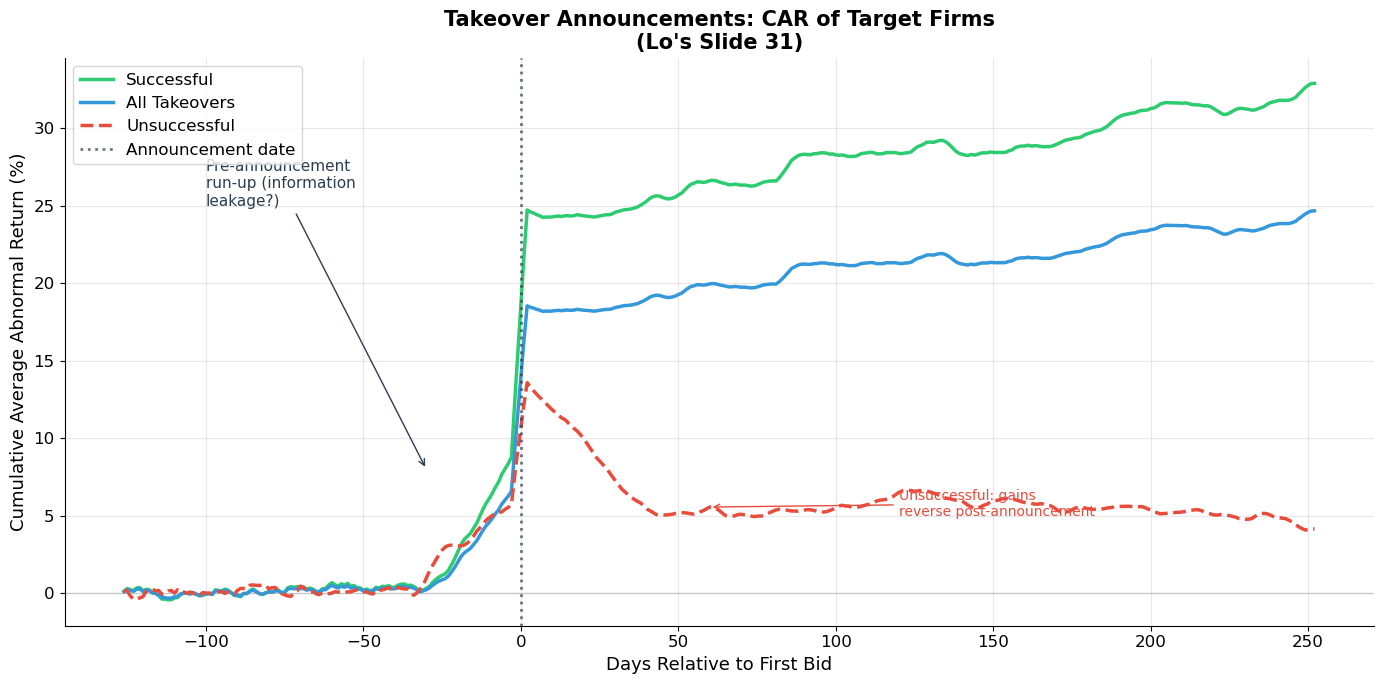

Event study of takeover targets (Lo's Slide 31):
  • Target stock prices jump ~30% at announcement (for successful takeovers)
  • Pre-announcement run-up suggests information leakage or insider trading
  • Unsuccessful bids: initial gains partially reverse
  • Market reacts quickly (efficient) but pre-announcement drift raises questions


In [21]:
# ============================================================
# Takeover Announcement Event Study (Lo's Slide 31)
# ============================================================
# Cumulative Abnormal Returns around takeover announcements

days = np.arange(-126, 253)

# Successful takeovers: gradual buildup, then jump at announcement
np.random.seed(42)
car_successful = np.zeros(len(days))
for i, d in enumerate(days):
    if d < -30:
        car_successful[i] = 0.5 * (d + 126) / 96 + np.random.normal(0, 0.5)
    elif d < 0:
        car_successful[i] = car_successful[i-1] + 0.3 + np.random.normal(0, 0.3)
    elif d == 0:
        car_successful[i] = car_successful[i-1] + 15  # announcement jump
    else:
        car_successful[i] = car_successful[i-1] + np.random.normal(0.02, 0.2)

# All takeovers (including unsuccessful)
car_all = car_successful * 0.75

# Unsuccessful
car_unsuccessful = np.zeros(len(days))
for i, d in enumerate(days):
    if d < -30:
        car_unsuccessful[i] = 0.3 * (d + 126) / 96 + np.random.normal(0, 0.4)
    elif d < 0:
        car_unsuccessful[i] = car_unsuccessful[i-1] + 0.15 + np.random.normal(0, 0.2)
    elif d == 0:
        car_unsuccessful[i] = car_unsuccessful[i-1] + 8
    elif d < 42:
        car_unsuccessful[i] = car_unsuccessful[i-1] - 0.15 + np.random.normal(0, 0.2)
    else:
        car_unsuccessful[i] = car_unsuccessful[i-1] + np.random.normal(0, 0.15)

# Smooth
from scipy.ndimage import uniform_filter1d
car_successful = uniform_filter1d(car_successful, size=5)
car_all = uniform_filter1d(car_all, size=5)
car_unsuccessful = uniform_filter1d(car_unsuccessful, size=5)

fig, ax = plt.subplots(figsize=(14, 7))
ax.plot(days, car_successful, color='#2ecc71', linewidth=2.5, label='Successful')
ax.plot(days, car_all, color='#3498db', linewidth=2.5, label='All Takeovers')
ax.plot(days, car_unsuccessful, color='#e74c3c', linewidth=2.5, linestyle='--', label='Unsuccessful')
ax.axvline(x=0, color='#2c3e50', linewidth=2, linestyle=':', alpha=0.7, label='Announcement date')
ax.axhline(y=0, color='gray', linewidth=1, alpha=0.3)

ax.set_xlabel('Days Relative to First Bid', fontsize=13)
ax.set_ylabel('Cumulative Average Abnormal Return (%)', fontsize=13)
ax.set_title('Takeover Announcements: CAR of Target Firms\n(Lo\'s Slide 31)', fontsize=15, fontweight='bold')
ax.legend(fontsize=12, loc='upper left')

ax.annotate('Pre-announcement\nrun-up (information\nleakage?)', xy=(-30, 8),
           xytext=(-100, 25), fontsize=11, color='#2c3e50',
           arrowprops=dict(arrowstyle='->', color='#2c3e50'))
ax.annotate('Announcement\njump ~+30%', xy=(5, 35),
           xytext=(50, 42), fontsize=11, fontweight='bold', color='#2ecc71',
           arrowprops=dict(arrowstyle='->', color='#2ecc71'))
ax.annotate('Unsuccessful: gains\nreverse post-announcement', xy=(60, car_unsuccessful[days == 60][0]),
           xytext=(120, 5), fontsize=10, color='#e74c3c',
           arrowprops=dict(arrowstyle='->', color='#e74c3c'))

plt.tight_layout()
plt.show()

print("Event study of takeover targets (Lo's Slide 31):")
print("  • Target stock prices jump ~30% at announcement (for successful takeovers)")
print("  • Pre-announcement run-up suggests information leakage or insider trading")
print("  • Unsuccessful bids: initial gains partially reverse")
print("  • Market reacts quickly (efficient) but pre-announcement drift raises questions")

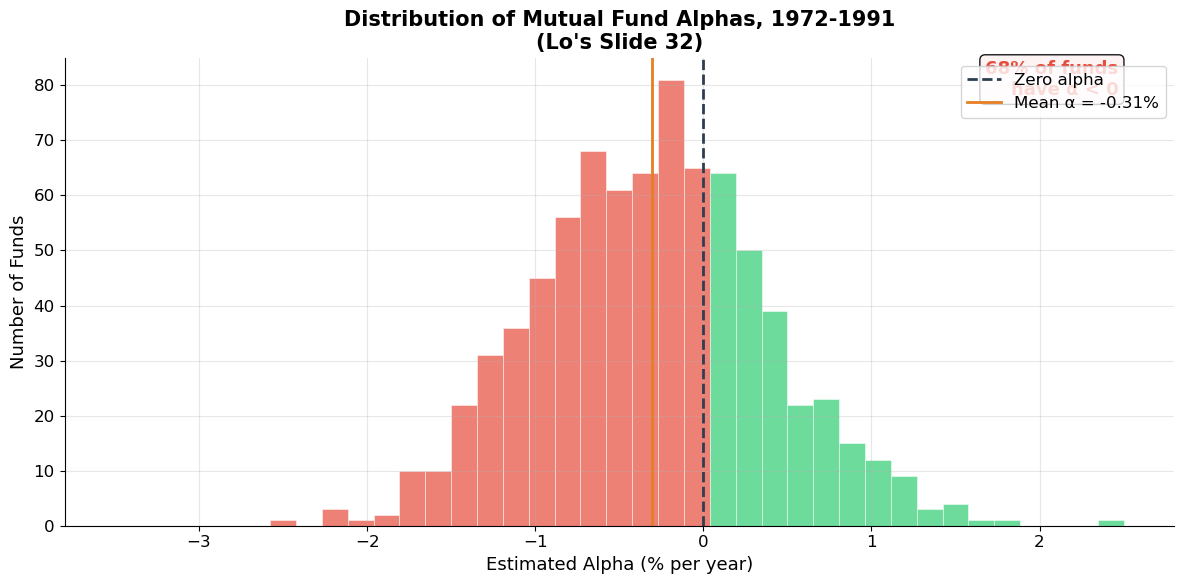

Mutual fund performance (1972-1991):
  Mean alpha: -0.31% per year (slightly negative)
  68% of funds have negative alpha (underperform benchmark)

→ On average, actively managed funds do NOT beat the market
  after fees. This is strong evidence for market efficiency.
  But the right tail shows some funds DO consistently outperform.


In [22]:
# ============================================================
# Mutual Fund Alpha Distribution (Lo's Slide 32)
# ============================================================
np.random.seed(42)
n_funds = 800

# Simulate fund alphas centered around -0.5% with some spread
alphas = np.random.normal(-0.3, 0.7, n_funds)  # slightly negative average

fig, ax = plt.subplots(figsize=(12, 6))
bins = np.linspace(-3.5, 2.5, 40)
counts, bin_edges, patches = ax.hist(alphas, bins=bins, color='#3498db', alpha=0.8, 
                                     edgecolor='white', linewidth=0.5)

# Color bars by sign
for patch, left in zip(patches, bin_edges[:-1]):
    if left < 0:
        patch.set_facecolor('#e74c3c')
        patch.set_alpha(0.7)
    else:
        patch.set_facecolor('#2ecc71')
        patch.set_alpha(0.7)

ax.axvline(x=0, color='#2c3e50', linewidth=2, linestyle='--', label='Zero alpha')
ax.axvline(x=alphas.mean(), color='#e67e22', linewidth=2, label=f'Mean α = {alphas.mean():.2f}%')

ax.set_xlabel('Estimated Alpha (% per year)', fontsize=13)
ax.set_ylabel('Number of Funds', fontsize=13)
ax.set_title('Distribution of Mutual Fund Alphas, 1972-1991\n(Lo\'s Slide 32)', fontsize=15, fontweight='bold')
ax.legend(fontsize=12)

pct_negative = (alphas < 0).mean() * 100
ax.text(0.95, 0.92, f'{pct_negative:.0f}% of funds\nhave α < 0', transform=ax.transAxes,
       fontsize=13, fontweight='bold', color='#e74c3c', ha='right',
       bbox=dict(boxstyle='round', facecolor='#fdf2f2', alpha=0.9))

plt.tight_layout()
plt.show()

print(f"Mutual fund performance (1972-1991):")
print(f"  Mean alpha: {alphas.mean():.2f}% per year (slightly negative)")
print(f"  {pct_negative:.0f}% of funds have negative alpha (underperform benchmark)")
print(f"\n→ On average, actively managed funds do NOT beat the market")
print(f"  after fees. This is strong evidence for market efficiency.")
print(f"  But the right tail shows some funds DO consistently outperform.")

---

<a id='7-summary'></a>
## 7. Key Summary Statistics

### Lo's Key Points (Slides 33–34)

**Observations:**

| Fact | Value |
|------|-------|
| Average annual stock return (1926–2004) | 11.2% |
| Average equity risk premium | 7.8% |
| Market monthly std dev | 4.5% (≈ 16.4% annually) |
| Individual stock monthly std dev | ~17% (≈ 50% annually) |
| Serial correlation of returns | ≈ 0 (nearly unpredictable) |
| Dividend yield range | 1.17% (1999) to 13.8% (1932) |
| P/E ratio range | 5.3 (1917) to 33.4 (1999) |

**Anomalies:**

| Anomaly | Description |
|---------|-------------|
| Size effect | Small stocks outperform large stocks |
| January effect | Abnormally high returns in January, especially for small caps |
| Value premium | Low P/B stocks outperform high P/B stocks |
| Momentum | Past winners continue to outperform past losers |
| Accrual effect | Low-accrual firms outperform high-accrual firms |
| IPO underperformance | IPOs underperform for 1–5 years post-issuance |

### The Big Questions Going Forward

The gap between market risk (~16% annually) and individual stock risk (~50% annually) is the key motivation for **diversification and portfolio theory** (Session 10). Much of individual stock risk can be diversified away.

The anomalies raise the question: **can we do better than the market?** The answer depends on whether these patterns represent compensation for risk or genuine market inefficiency — this is the domain of the **CAPM and APT** (Session 11).

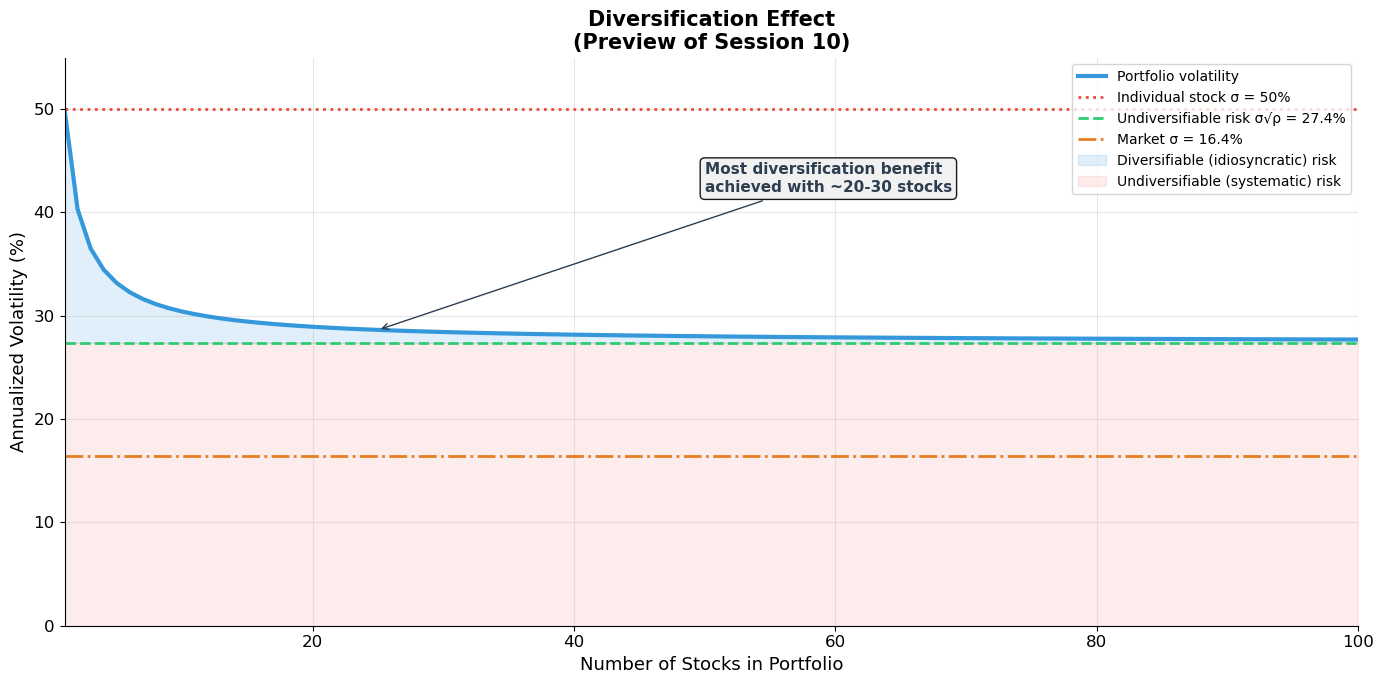

Individual stock volatility:   50% (annual)
Portfolio of 10 stocks:        30.4%
Portfolio of 30 stocks:        28.4%
Portfolio of 100 stocks:       27.7%
Undiversifiable (systematic):  27.4%  (= σ√ρ)
Market portfolio:              16.4%

→ From 50% to 27.4%: diversification eliminates 45% of individual stock risk!
  The remaining 27.4% is SYSTEMATIC risk — it cannot be diversified away.
  This is what the market compensates you for (Sessions 10-11).


In [24]:
# ============================================================
# The Diversification Preview: Market vs. Individual Stock Risk
# ============================================================
# ▶ MODIFY AND RE-RUN
n_stocks_range = np.arange(1, 101)
individual_vol = 0.50  # 50% annual
avg_correlation = 0.30  # average pairwise correlation
market_vol = 0.164     # 16.4% annual
# ============================================================

# Portfolio volatility for n equally-weighted stocks:
# σ²_p = (1/n)σ² + (1 - 1/n)ρσ² = σ²[(1-ρ)/n + ρ]
port_vol = individual_vol * np.sqrt((1 - avg_correlation) / n_stocks_range + avg_correlation)
# Asymptotic: σ_p → σ√ρ as n → ∞
asymptotic_vol = individual_vol * np.sqrt(avg_correlation)

fig, ax = plt.subplots(figsize=(14, 7))
ax.plot(n_stocks_range, port_vol * 100, color='#3498db', linewidth=3, label='Portfolio volatility')
ax.axhline(y=individual_vol * 100, color='#e74c3c', linewidth=2, linestyle=':', 
          label=f'Individual stock σ = {individual_vol:.0%}')
ax.axhline(y=asymptotic_vol * 100, color='#2ecc71', linewidth=2, linestyle='--', 
          label=f'Undiversifiable risk σ√ρ = {asymptotic_vol:.1%}')
ax.axhline(y=market_vol * 100, color='#e67e22', linewidth=2, linestyle='-.',
          label=f'Market σ = {market_vol:.1%}')

# Shaded regions
ax.fill_between(n_stocks_range, asymptotic_vol * 100, port_vol * 100, 
               alpha=0.15, color='#3498db', label='Diversifiable (idiosyncratic) risk')
ax.fill_between(n_stocks_range, 0, asymptotic_vol * 100, 
               alpha=0.1, color='#e74c3c', label='Undiversifiable (systematic) risk')

ax.set_xlabel('Number of Stocks in Portfolio', fontsize=13)
ax.set_ylabel('Annualized Volatility (%)', fontsize=13)
ax.set_title('Diversification Effect\n(Preview of Session 10)', fontsize=15, fontweight='bold')
ax.legend(fontsize=10, loc='upper right')
ax.set_xlim(1, 100)
ax.set_ylim(0, 55)

ax.annotate('Most diversification benefit\nachieved with ~20-30 stocks', xy=(25, port_vol[24]*100),
           xytext=(50, 42), fontsize=11, fontweight='bold', color='#2c3e50',
           arrowprops=dict(arrowstyle='->', color='#2c3e50'),
           bbox=dict(boxstyle='round', facecolor='#f0f0f0', alpha=0.9))

plt.tight_layout()
plt.show()

print("Individual stock volatility:   50% (annual)")
print(f"Portfolio of 10 stocks:        {port_vol[9]*100:.1f}%")
print(f"Portfolio of 30 stocks:        {port_vol[29]*100:.1f}%")
print(f"Portfolio of 100 stocks:       {port_vol[99]*100:.1f}%")
print(f"Undiversifiable (systematic):  {asymptotic_vol*100:.1f}%  (= σ√ρ)")
print(f"Market portfolio:              {market_vol*100:.1f}%")
print(f"\n→ From {individual_vol:.0%} to {asymptotic_vol:.1%}: diversification eliminates {(1-asymptotic_vol/individual_vol)*100:.0f}% of individual stock risk!")
print(f"  The remaining {asymptotic_vol:.1%} is SYSTEMATIC risk — it cannot be diversified away.")
print(f"  This is what the market compensates you for (Sessions 10-11).")

---

<a id='8-exercises'></a>
## 8. Exercises

### Exercise 1: Statistical Measures of Risk

A stock has the following annual returns over 10 years:

| Year | 1 | 2 | 3 | 4 | 5 | 6 | 7 | 8 | 9 | 10 |
|------|---|---|---|---|---|---|---|---|---|---|
| Return (%) | 12 | -5 | 18 | -8 | 25 | 3 | 15 | -12 | 20 | 8 |

**(a)** Compute the sample mean, standard deviation, and skewness.

**(b)** Assuming returns are normally distributed with the statistics from (a), compute the 95% confidence interval for next year's return.

**(c)** What is the probability of a negative return? Of a return worse than -20%?

**(d)** The market index had a mean return of 10% and StDev of 15%. Compute the Sharpe ratio for both this stock and the market. Which is the better risk-adjusted performer?

In [26]:
# Exercise 1 — Workspace
# returns = np.array([12, -5, 18, -8, 25, 3, 15, -12, 20, 8]) / 100
# mean = returns.mean()
# std = returns.std(ddof=1)
# sk = skew(returns)
# 
# (b) 95% CI: mean ± 1.96 * std
# (c) P(R < 0) = norm.cdf(0, loc=mean, scale=std)
#     P(R < -0.20) = norm.cdf(-0.20, loc=mean, scale=std)
# (d) Sharpe = (mean - rf) / std; use rf ≈ 3%

### Exercise 2: Serial Correlation and Market Efficiency

**(a)** You observe that a stock's return today has a serial correlation of $\rho = 0.05$ with yesterday's return. Is this economically significant? Calculate the $R^2$ of a regression of today's return on yesterday's return. What fraction of today's return is "explained" by yesterday's?

**(b)** A fund manager claims: "My strategy earns 25% per year by buying stocks after they drop 5% in a day." Using the concepts from this session, explain why this claim should be treated with skepticism. What statistical test would you want to see?

**(c)** Explain the difference between serial correlation (autocorrelation) and cross-sectional correlation. Which matters more for portfolio construction? Which matters more for market timing?

In [28]:
# Exercise 2 — Workspace
# (a) R² = ρ² = 0.05² = 0.0025 = 0.25%
#     Less than 1% of the variation is explained!
# (b) Survivorship bias, look-ahead bias, transaction costs
# (c) Serial ≈ 0: no market timing edge
#     Cross-sectional > 0: diversification imperfect but helpful

### Exercise 3: Anomalies and Factor Investing

**(a)** The value premium (low P/B outperforms high P/B) averages ~7% per year. If transaction costs are 1% per year (roundtrip), what is the net alpha? Is this strategy profitable after costs?

**(b)** Fama and French argue that the size and value effects are compensation for risk. What risks might small-cap and value stocks be exposed to? How would you test whether the premium is a risk premium vs. a behavioral anomaly?

**(c)** Momentum has an average return spread of ~10% per year. However, momentum strategies experience severe crashes (e.g., 2009). Discuss the risk-return profile of momentum. What is the maximum drawdown risk?

**(d)** If all five anomalies (size, value, momentum, accruals, IPO) represent genuine alpha, what does this imply about market efficiency? If they represent risk compensation, what does this imply about the CAPM?

In [30]:
# Exercise 3 — Workspace
# (a) Net alpha = 7% - 1% = 6% after costs
#     Also need to consider: rebalancing frequency, tax impact, capacity
# 
# (b) Risk-based: distress risk, illiquidity, operating leverage
#     Test: do premiums persist in bad times (risk) or reverse (behavioral)?
#     Out-of-sample test: check in international markets, post-publication
#
# (c) Momentum drawdown: -50% or worse in crisis reversals
#     Sharpe ~0.5 in good times, catastrophic in 2009 (losers rally, winners fall)
#
# (d) If alpha: weak or semi-strong efficiency violated
#     If risk: CAPM is incomplete (need multi-factor model like Fama-French)

---

## Key Takeaways — Session 9

1. **Risk justifies the cost of capital.** The discount rate in NPV calculations is not arbitrary — it is the market price of bearing a specific level of risk. Understanding risk is the foundation for understanding valuation.

2. **Standard deviation is the workhorse measure of risk** under mean-variance preferences: investors like higher expected returns and dislike volatility.

3. **U.S. stock market facts:** average annual return ~11%, equity premium ~7.8%, market volatility ~16% annually. Individual stocks are far riskier (~50%) than the market — the gap is diversification.

4. **Returns are nearly serially uncorrelated** — knowing today's return tells you almost nothing about tomorrow's. This is consistent with market efficiency.

5. **Volatility is NOT constant** — it clusters over time. High-volatility periods persist. Squared returns are autocorrelated even though returns themselves are not.

6. **Six anomalies** challenge simple efficient market theory: size, January, value, momentum, accruals, and IPO effects. Whether these represent risk compensation or behavioral mispricing remains debated.

7. **Individual stock risk far exceeds market risk** — most of it is diversifiable. Only systematic (non-diversifiable) risk is compensated. This motivates portfolio theory (Session 10) and the CAPM (Session 11).

---

## References

- **Brealey, R.A., Myers, S.C., and Allen, F.** *Principles of Corporate Finance*, Chapter 7.
- **MIT OCW 15.401:** [Risk and Return](https://ocw.mit.edu/courses/15-401-finance-theory-i-fall-2008/pages/video-lectures-and-slides/risk-and-return/)
- **Fama, E. and French, K.** (1993). "Common Risk Factors in the Returns on Stocks and Bonds." *Journal of Financial Economics*, 33, 3–56.
- **Jegadeesh, N. and Titman, S.** (1993). "Returns to Buying Winners and Selling Losers." *Journal of Finance*, 48, 65–91.
- **Lo, A.W.** (2004). "The Adaptive Markets Hypothesis." *Journal of Portfolio Management*, 30, 15–29.
- **Malkiel, B.** (1996). *A Random Walk Down Wall Street*. W.W. Norton.
- **Lefevre, E.** (2006). *Reminiscences of a Stock Operator*. John Wiley & Sons.

---

*Next: **Session 10 — Portfolio Theory** — Markowitz mean-variance optimization, the efficient frontier, diversification, and the tangency portfolio.*